# Deforestation Dataset

This notebook prepares the deforestation dataset

In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import random
InteractiveShell.ast_node_interactivity = "all"
import os
from datetime import datetime, timedelta
from tqdm import tqdm
import cv2
import glob

from multiearth_challenge.datasets import segmentation_dataset as sd
from multiearth_challenge.datasets import base_datasets as bd
from multiearth_challenge import tiff_file_tools as tft
from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
from src.extract_sat_images import get_forest_target

In [3]:
def get_forest_target():
    rows = []
    for mode in [
        "train",
        "test",
        "val",
        ]:
        forest_target_files = glob.glob(f"data/multiearth2023-dataset-final/forest_{mode}/Defores*.tiff", recursive=True)
        print(mode, len(forest_target_files))

        for tiff_path in tqdm(forest_target_files):
            d = tft.parse_filename_parts(tiff_path)
            d['target_path'] = tiff_path
            d['mode'] = mode
            
            img = cv2.imread(tiff_path)
            img = img.clip(0, 1)
            img = img[:, :, 0]
            d['img_mean'] = img.mean()
            rows.append(d)
    forest_target = pd.DataFrame(rows)
    return forest_target

In [4]:
forest_target = get_forest_target()
# forest_target = pd.read_csv('forest_target.csv')
forest_target.head()
forest_target.shape

forest_target.lat.min(), forest_target.lat.max()
forest_target.lon.min(), forest_target.lon.max()
forest_target.img_mean.max()

train 17215


100%|██████████| 17215/17215 [12:05<00:00, 23.72it/s]


test 2970


100%|██████████| 2970/2970 [05:04<00:00,  9.77it/s]


val 1782


100%|██████████| 1782/1782 [03:01<00:00,  9.82it/s]


,sensor,band,lat,lon,date,target_path,mode,img_mean
0,Deforestation,,-3.95,-55.08,2018-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.000000
1,Deforestation,,-3.55,-54.98,2021-05-01,data/multiearth2023-dataset-final/forest_train...,train,0.000000
2,Deforestation,,-3.67,-54.58,2021-05-01,data/multiearth2023-dataset-final/forest_train...,train,0.375946
3,Deforestation,,-3.61,-54.62,2018-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.009018
4,Deforestation,,-4.33,-55.02,2019-07-01,data/multiearth2023-dataset-final/forest_train...,train,0.011993


(21967, 8)

(-4.39, -3.33)

(-55.2, -54.48)

1.0

In [5]:
DATA_PATH = 'data/multiearth2023-dataset-final/'
DP_PATH = './dp'

# Spatial grid CV

In [6]:
N_FOLDS = 5

lat_lons = pd.concat([
    forest_target
])[['lat', 'lon']].drop_duplicates()

lat_lons['lat_cat'] = (lat_lons.lat * 8).astype(int)
lat_lons['lon_cat'] = (lat_lons.lon * 8).astype(int)
lat_lons['cv'] = (lat_lons.lon_cat + lat_lons.lat_cat) % N_FOLDS
lat_lons.shape
lat_lons.head()

lat_lons.to_csv('grid_cv.csv', index=False)

sorted(lat_lons.lat_cat.unique())
sorted(lat_lons.lon_cat.unique())

(1997, 5)

,lat,lon,lat_cat,lon_cat,cv
0,-3.95,-55.08,-31,-440,4
1,-3.55,-54.98,-28,-439,3
2,-3.67,-54.58,-29,-436,0
3,-3.61,-54.62,-28,-436,1
4,-4.33,-55.02,-34,-440,1


[-35, -34, -33, -32, -31, -30, -29, -28, -27, -26]

[-441, -440, -439, -438, -437, -436, -435]

In [7]:
forest_target['mode_id'] = forest_target['mode'].replace({'train': 0, 'val': 1, 'test': 2})
forest_target['is_forest'] = (forest_target['img_mean'] == 0.)
forest_target.groupby('mode')[['is_forest', 'img_mean']].mean()

,is_forest,img_mean
mode,,
test,0.116498,0.352047
train,0.442986,0.191894
val,0.259259,0.183910


In [8]:
forest_target.groupby('date').img_mean.mean()

date
2016-08-01    0.185462
2017-07-01    0.195725
2017-08-01    0.199891
2018-06-01    0.208584
2018-08-01    0.209846
2019-07-01    0.219593
2019-08-01    0.222973
2020-06-01    0.219828
2020-08-01    0.227440
2021-05-01    0.241238
2021-08-01    0.211312
Name: img_mean, dtype: float64

Text(0.5, 1.0, 'train-test split')

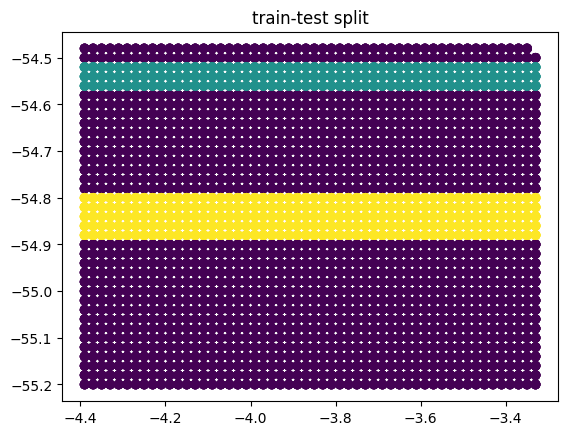

In [9]:
plt.scatter(
    x=forest_target.lat.values,
    y=forest_target.lon.values,
    c=forest_target['mode_id'].values,
    alpha=0.5,
)
plt.title('train-test split')

Text(0.5, 1.0, 'Deforestation')

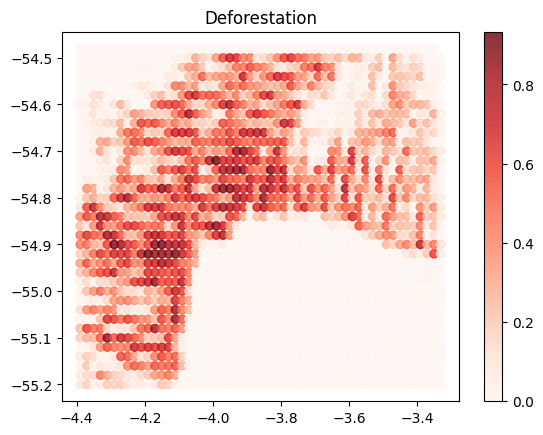

In [10]:
forest_map = forest_target.groupby(['lat', 'lon']).img_mean.mean().reset_index()
plt.scatter(
    x=forest_map.lat.values,
    y=forest_map.lon.values,
    c=forest_map['img_mean'].values,
    alpha=0.8,
    cmap=plt.cm.Reds
)
plt.colorbar()
plt.title("Deforestation")

Text(0.5, 1.0, 'Forests')

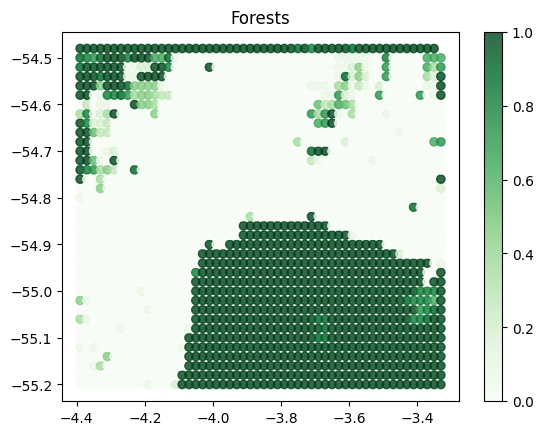

In [11]:
forest_map = forest_target.groupby(['lat', 'lon']).is_forest.mean().reset_index()
plt.scatter(
    x=forest_map.lat.values,
    y=forest_map.lon.values,
    c=forest_map['is_forest'].values,
    alpha=0.8,
    cmap=plt.cm.Greens
)
plt.colorbar()
plt.title("Forests")

In [12]:
forest_target.shape
forest_target.head()
forest_target.tail()

(21967, 10)

,sensor,band,lat,lon,date,target_path,mode,img_mean,mode_id,is_forest
0,Deforestation,,-3.95,-55.08,2018-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.000000,0,True
1,Deforestation,,-3.55,-54.98,2021-05-01,data/multiearth2023-dataset-final/forest_train...,train,0.000000,0,True
2,Deforestation,,-3.67,-54.58,2021-05-01,data/multiearth2023-dataset-final/forest_train...,train,0.375946,0,False
3,Deforestation,,-3.61,-54.62,2018-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.009018,0,False
4,Deforestation,,-4.33,-55.02,2019-07-01,data/multiearth2023-dataset-final/forest_train...,train,0.011993,0,False


,sensor,band,lat,lon,date,target_path,mode,img_mean,mode_id,is_forest
21962,Deforestation,,-4.11,-54.52,2017-07-01,data/multiearth2023-dataset-final/forest_val/D...,val,0.094574,1,False
21963,Deforestation,,-3.45,-54.52,2020-06-01,data/multiearth2023-dataset-final/forest_val/D...,val,0.149963,1,False
21964,Deforestation,,-4.35,-54.54,2017-08-01,data/multiearth2023-dataset-final/forest_val/D...,val,0.000000,1,True
21965,Deforestation,,-3.89,-54.54,2019-08-01,data/multiearth2023-dataset-final/forest_val/D...,val,0.365967,1,False
21966,Deforestation,,-4.15,-54.54,2018-08-01,data/multiearth2023-dataset-final/forest_val/D...,val,0.000000,1,True


In [13]:
train_df = forest_target[forest_target['mode'] == 'train']
train_df.shape
# train_df = train_df.merge(lons, on=['lon'])
train_df = train_df.merge(lat_lons, on=['lat', 'lon'])
train_df.shape
train_df.head()


(17215, 10)

(17215, 13)

,sensor,band,lat,lon,date,target_path,mode,img_mean,mode_id,is_forest,lat_cat,lon_cat,cv
0,Deforestation,,-3.95,-55.08,2018-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.0,0,True,-31,-440,4
1,Deforestation,,-3.95,-55.08,2018-06-01,data/multiearth2023-dataset-final/forest_train...,train,0.0,0,True,-31,-440,4
2,Deforestation,,-3.95,-55.08,2019-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.0,0,True,-31,-440,4
3,Deforestation,,-3.95,-55.08,2017-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.0,0,True,-31,-440,4
4,Deforestation,,-3.95,-55.08,2019-07-01,data/multiearth2023-dataset-final/forest_train...,train,0.0,0,True,-31,-440,4


Text(0.5, 1.0, 'validation splits')

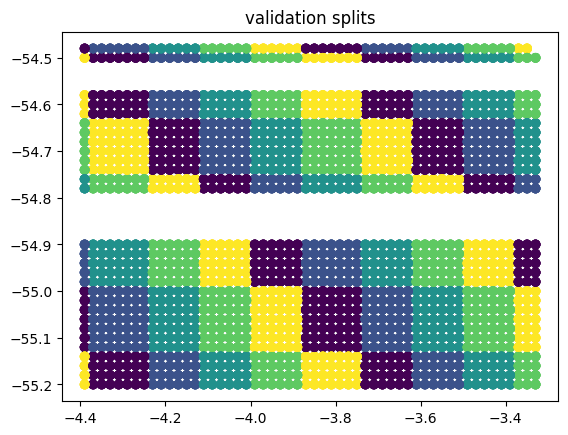

In [14]:
plt.scatter(
    x=train_df.lat.values,
    y=train_df.lon.values,
    c=train_df['cv'].values,
    alpha=0.5,
)
plt.title('validation splits')

In [15]:
# Spatial sampling
if False:
    lat_lons_w_forest = train_df.groupby(['lat', 'lon']).img_mean.mean().reset_index()
    fig = plt.subplots()
    lat_lons_w_forest.img_mean.hist(bins=50)

    deforest_threshold = 0.01
    forests = lat_lons_w_forest[lat_lons_w_forest.img_mean < deforest_threshold]
    rest = lat_lons_w_forest[lat_lons_w_forest.img_mean >= deforest_threshold]
    forests.shape, rest.shape

    balanced_lat_lons = pd.concat([
        forests.sample(frac=0.2),  # use less forests in training set
        rest]
    )
    balanced_lat_lons.shape
    balanced_lat_lons.head()

    fig = plt.subplots()
    plt.scatter(
        x=balanced_lat_lons.lat.values,
        y=balanced_lat_lons.lon.values,
        s=2,
    )
    #     balanced_lat_lons.to_csv('balanced_lat_lons_v2.csv', index=False)

balanced_lat_lons = pd.read_csv('balanced_lat_lons_v2.csv')

balanced_lat_lons.shape
balanced_lat_lons.head()

(1003, 3)

,lat,lon,img_mean
0,-4.01,-54.96,0.0
1,-3.77,-54.90,0.0
2,-3.97,-55.02,0.0
3,-4.27,-54.50,0.0
4,-3.57,-54.96,0.0


<Axes: xlabel='date'>

<Axes: xlabel='date'>

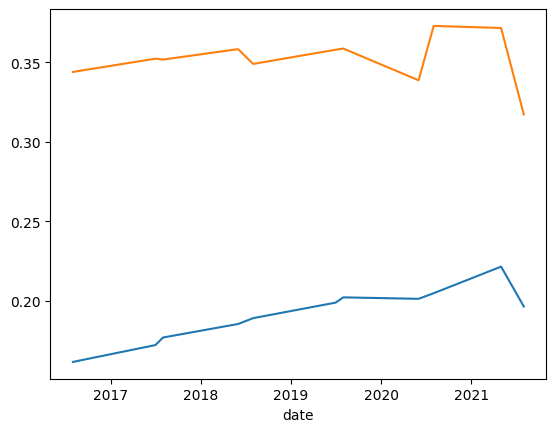

In [17]:
#time split
train_df.groupby('date').img_mean.mean().plot()
forest_target[forest_target['mode'] =='test'].groupby('date').img_mean.mean().plot()
# forest_target[forest_target['mode'] =='val'].groupby('date').is_forest.mean().plot()

In [18]:
forest_target.groupby('date').count()

,sensor,band,lat,lon,target_path,mode,img_mean,mode_id,is_forest
date,,,,,,,,,
2016-08-01,1997,1997,1997,1997,1997,1997,1997,1997,1997
2017-07-01,1997,1997,1997,1997,1997,1997,1997,1997,1997
2017-08-01,1997,1997,1997,1997,1997,1997,1997,1997,1997
2018-06-01,1997,1997,1997,1997,1997,1997,1997,1997,1997
2018-08-01,1997,1997,1997,1997,1997,1997,1997,1997,1997
2019-07-01,1997,1997,1997,1997,1997,1997,1997,1997,1997
2019-08-01,1997,1997,1997,1997,1997,1997,1997,1997,1997
2020-06-01,1997,1997,1997,1997,1997,1997,1997,1997,1997
2020-08-01,1997,1997,1997,1997,1997,1997,1997,1997,1997


In [19]:
X = train_df[['lat', 'lon', 'date', 'target_path', 'cv', 'img_mean', 'is_forest']].copy()
X.shape
X.cv.value_counts()

for cv in train_df.cv.unique():
    tr = train_df[train_df.cv != cv]
    tr.to_csv(f'deforest_train_cv{cv}.csv', index=False)
    val = train_df[train_df.cv == cv]
    # balanced validation dataset
    val = val.merge(balanced_lat_lons[['lat', 'lon']], how='inner', on=['lat', 'lon'])
    # speed
    val = val.sample(n=1200)
    val.to_csv(f'deforest_valid_cv{cv}.csv', index=False)
    cv, tr.shape, val.shape

(17215, 7)

cv
1    3630
2    3597
0    3399
3    3322
4    3267
Name: count, dtype: int64

(4, (13948, 13), (1200, 13))

(3, (13893, 13), (1200, 13))

(0, (13816, 13), (1200, 13))

(1, (13585, 13), (1200, 13))

(2, (13618, 13), (1200, 13))

In [20]:
val.sample(n=100)

,sensor,band,lat,lon,date,target_path,mode,img_mean,mode_id,is_forest,lat_cat,lon_cat,cv
2166,Deforestation,,-4.15,-55.08,2017-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.678131,0,False,-33,-440,2
846,Deforestation,,-3.35,-54.66,2019-07-01,data/multiearth2023-dataset-final/forest_train...,train,0.247147,0,False,-26,-437,2
52,Deforestation,,-4.31,-54.98,2021-05-01,data/multiearth2023-dataset-final/forest_train...,train,0.182205,0,False,-34,-439,2
712,Deforestation,,-4.09,-55.16,2021-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.218658,0,False,-32,-441,2
1722,Deforestation,,-4.13,-55.12,2018-06-01,data/multiearth2023-dataset-final/forest_train...,train,0.615936,0,False,-33,-440,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254,Deforestation,,-4.11,-55.14,2021-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.546219,0,False,-32,-441,2
2162,Deforestation,,-4.15,-55.08,2018-06-01,data/multiearth2023-dataset-final/forest_train...,train,0.506165,0,False,-33,-440,2
971,Deforestation,,-3.65,-54.92,2017-07-01,data/multiearth2023-dataset-final/forest_train...,train,0.000000,0,True,-29,-439,2
397,Deforestation,,-4.35,-54.98,2021-08-01,data/multiearth2023-dataset-final/forest_train...,train,0.016708,0,False,-34,-439,2


In [21]:
# Full training set
cv = -1
tr = train_df.copy()
val = val.sample(n=100)
tr.to_csv(f'deforest_train_cv{cv}.csv', index=False)
val.to_csv(f'deforest_valid_cv{cv}.csv', index=False)
tr.shape, val.shape

((17215, 13), (100, 13))

## Test targets

In [22]:
df = pd.read_csv('data/multiearth2023-dataset-final/deforestation_segmentation_targets.csv')

In [23]:
ds = bd.NetCDFDataset(
    netcdf_file='data/multiearth2023-dataset-final/deforestation_segmentation_targets.nc',
    data_filters=[],
    merge_bands=False,
)
len(ds)

1000

In [24]:
# !rm -rf data/multiearth2023-dataset-final/forest_target

In [25]:
forest_target_dir = 'data/multiearth2023-dataset-final/forest_target'
os.makedirs(forest_target_dir, exist_ok=True)
rows = []
for d in tqdm(ds):
    lat, lon = d['lat_lon'].round(2)
    img = np.zeros((256, 256, 3)).astype(np.int8)
    target_date = pd.to_datetime(d['date'])
    
    f = f'Deforestation_{lon:.2f}_{lat:.2f}_{target_date.strftime("%Y_%m_%d")}.tiff'
    target_path = f"{forest_target_dir}/{f}"
    _ = cv2.imwrite(target_path, img)
    row = [target_date.strftime("%Y-%m-%d"), target_path, lat, lon]
    rows.append(row)
    

100%|██████████| 1000/1000 [00:01<00:00, 681.72it/s]


In [26]:
deforest_targets = pd.DataFrame(rows, columns=[
    'date', 'target_path', 'lat', 'lon'
])
deforest_targets.shape
deforest_targets.to_csv('deforest_targets.csv', index=False)
deforest_targets.head()
len(os.listdir(forest_target_dir))

(1000, 4)

,date,target_path,lat,lon
0,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-4.07,-54.80
1,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-4.11,-54.80
2,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-3.95,-54.80
3,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-4.23,-54.82
4,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-4.25,-54.88


1000

In [27]:
deforest_targets.date.value_counts()

date
2021-05-01    109
2020-08-01     97
2019-07-01     94
2021-08-01     93
2017-08-01     92
2019-08-01     92
2018-06-01     87
2020-06-01     87
2016-08-01     87
2018-08-01     86
2017-07-01     76
Name: count, dtype: int64

# Check test distribution

Text(0.5, 1.0, 'validation splits')

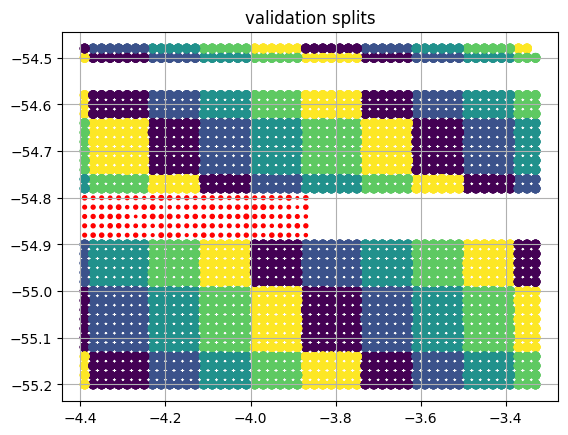

In [28]:
plt.scatter(
    x=train_df.lat.values,
    y=train_df.lon.values,
    c=train_df['cv'].values,
    alpha=0.5,
)

target_latlons = deforest_targets.groupby(['lat', 'lon']).nunique().reset_index()
plt.scatter(
    x = target_latlons.lat,
    y = target_latlons.lon,
    s = target_latlons.date,
    c = 'red'
)
plt.grid()
plt.title('validation splits')

Text(0.5, 1.0, 'Deforestation')

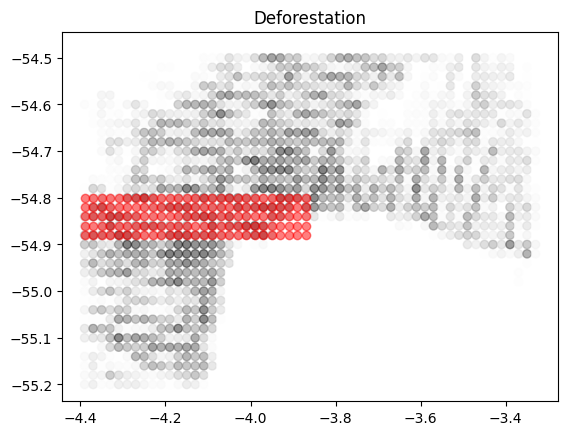

In [29]:
forest_map = forest_target.groupby(['lat', 'lon']).img_mean.mean().reset_index()
plt.scatter(
    x=forest_map.lat.values,
    y=forest_map.lon.values,
    c=forest_map['img_mean'].values,
    alpha=0.5,
    cmap=plt.cm.Greys
)
plt.scatter(
    x = target_latlons.lat,
    y = target_latlons.lon,
#     s = target_latlons.date,
    c = 'red',
    alpha=0.5
)

# plt.colorbar()
plt.title("Deforestation")